In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [2]:
import cirq
import cirq_superstaq as css
import ldpc
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pymatching
import sinter
import stim
import stimcirq
from ldpc.sinter_decoders import SinterBeliefFindDecoder, SinterBpOsdDecoder

import qldpc

In [44]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=3,
    distance=3,
    after_clifford_depolarization=0.01,
    after_reset_flip_probability=0.01,
    before_measure_flip_probability=0.01,
    before_round_data_depolarization=0.01)
surface_code_circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19
    X_ERROR(0.01) 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    X_ERROR(0.01) 2 9 11 13 14 16 18 25
    TICK
    DEPOLARIZE1(0.01) 1 3 5 8 10 12 15 17 19
    H 2 11 16 25
    DEPOLARIZE1(0.01) 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    DEPOLARIZE2(0.01) 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    DEPOLARIZE2(0.01) 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    DEPOLARIZE2(0.01) 16 10 11 5 25 19 8 9 17 18 12 

In [218]:
converted_circuit = stimcirq.stim_circuit_to_cirq_circuit(surface_code_circuit)[:18]

┌───┐   ┌─────────────────────┐   ┌──┐   ┌──────────────┐   ┌──┐   ┌──────────────┐   ┌───┐   ┌─────────────────────┐
(0, 4): ───────R──────────────X[prob=0.01]────────────────────────X───────#2─────────────────────────X────────────#2───────────────────────────────────────────────────────────────────────────────────X[prob=0.01]───MR('4')───X[prob=0.01]───
                                                                  │       │                          │            │
(1, 1): ───R───X[prob=0.01]──────────────────D(0.01)──────────────┼───────┼─────────────────────────X┼─────#2─────┼──────────────────────────────────────@─────────────D(0.01)─────────────────────────────────────────────────────────────────
                                                                  │       │                         ││     │      │                                      │             │
(1, 3): ───R───X[prob=0.01]──────────────────D(0.01)──────────────┼───────┼─────────────────────────┼@─────┼──────D(0.01)─────@──────D(0.01)────────────X┼──────#2─────┼───────────────────────────────────────────────────────────────────────
                                                                  │       │                         │      │                  │      │                  ││      │      │
(1, 5): ───R───X[prob=0.01]──────────────────D(0.01)──────────────@───────D(0.01)───────────────────┼X─────┼──────#2──────────┼──────┼──────────────────┼┼──────┼──────┼───────────────────────────────────────────────────────────────────────
                                                                                                    ││     │      │           │      │                  ││      │      │
(2, 0): ───────R──────────────X[prob=0.01]───H─────────D(0.01)────@───────D(0.01)───────────────────@┼─────D(0.01)┼───────────┼──────┼──────────────────┼┼──────┼──────┼─────────────────H───D(0.01)───X[prob=0.01]───MR('0')───X[prob=0.01]───
                                                                  │       │                          │            │           │      │                  ││      │      │
(2, 2): ───────R──────────────X[prob=0.01]────────────────────────┼─X─────┼─────────────#2──────────X┼─────#2─────┼───────────X──────#2─────────────────┼X──────┼──────#2──────────────────────────────X[prob=0.01]───MR('1')───X[prob=0.01]───
                                                                  │ │     │             │           ││     │      │                                     │       │
(2, 4): ───────R──────────────X[prob=0.01]───H─────────D(0.01)────┼@┼─────┼──────D(0.01)┼───────────┼@─────┼──────D(0.01)─────@──────D(0.01)────────────@───────D(0.01)──────────────────H───D(0.01)───X[prob=0.01]───MR('5')───X[prob=0.01]───
                                                                  │││     │      │      │           │      │                  │      │
(3, 1): ───R───X[prob=0.01]──────────────────D(0.01)──────────────X┼┼─────#2─────┼──────┼───────────@──────D(0.01)────────────┼──────┼──────────────────X───────#2─────────────────────────────────────────────────────────────────────────────
                                                                   ││            │      │                                     │      │                  │       │
(3, 3): ───R───X[prob=0.01]──────────────────D(0.01)───────────────┼@────────────┼──────D(0.01)─────X──────#2─────────────────X──────#2─────────────────┼─@─────┼─────────────D(0.01)──────────────────────────────────────────────────────────
                                                                   │             │                  │      │                                            │ │     │             │
(3, 5): ───R───X[prob=0.01]──────────────────D(0.01)───────────────X─────────────#2─────────────────┼──────┼───────────────────@────────────D(0.01)─────┼X┼─────┼──────#2─────┼────────────────────────────────────────────────────────────────
                                                       

In [4]:
# [X,Z] gates don't contribute to [X, Z] basis SPAM

In [210]:
d = 3
noise = 0.01
code = qldpc.codes.SurfaceCode(d, rotated=True)
circuit = gen_syndrome_surface_circuit(code, sector = "Z", repetitions=3).with_noise(NoiseModel(noise))
stimcirq.cirq_circuit_to_stim_circuit(circuit)

[cirq.NamedQubit('az0'), cirq.NamedQubit('az1'), cirq.NamedQubit('az2'), cirq.NamedQubit('az3'), cirq.NamedQubit('ax0'), cirq.NamedQubit('ax1'), cirq.NamedQubit('ax2'), cirq.NamedQubit('ax3')]


stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8
    RX 13 14 15 16 9 10 11 12
    TICK
    X_ERROR(0.01) 0 1 2 3 4 5 6 7 8
    Z_ERROR(0.01) 13 14 15 16 9 10 11 12
    TICK
    Z_ERROR(0.01) 13 14 15 16
    TICK
    MRX 13 14 15 16
    TICK
    Z_ERROR(0.01) 13 14 15 16
    TICK
    CX 9 0
    TICK
    DEPOLARIZE2(0.01) 9 0
    TICK
    CX 9 1
    TICK
    DEPOLARIZE2(0.01) 9 1
    TICK
    CX 9 3
    TICK
    DEPOLARIZE2(0.01) 9 3
    TICK
    CX 9 4
    TICK
    DEPOLARIZE2(0.01) 9 4
    TICK
    CX 10 2
    TICK
    DEPOLARIZE2(0.01) 10 2
    TICK
    CX 10 5
    TICK
    DEPOLARIZE2(0.01) 10 5
    TICK
    CX 11 3
    TICK
    DEPOLARIZE2(0.01) 11 3
    TICK
    CX 11 6
    TICK
    DEPOLARIZE2(0.01) 11 6
    TICK
    CX 12 4
    TICK
    DEPOLARIZE2(0.01) 12 4
    TICK
    CX 12 5
    TICK
    DEPOLARIZE2(0.01) 12 5
    TICK
    CX 12 7
    TICK
    DEPOLARIZE2(0.01) 12 7
    TICK
    CX 12 8
    TICK
    DEPOLARIZE2(0.01) 12 8
    TICK
    Z_ERROR(0.01) 9 10 11 12
    TICK
    MRX 9 10 

In [209]:
circuit

[ 0: ─────@───#2────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                                                                                   [         │   │                                                                                                                                                                                                                                                                            ]
                                                                                                                                                                                                                                                                                                   [ 1: ─────┼───┼─────────@───#2────────@───#2────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                                                                                   [         │   │         │   │         │   │                                                                                                                                                                                                                                                ]
                                                                                                                                                                                                                                                                                                   [ 2: ─────┼───┼─────────┼───┼─────────┼───┼─────────@───#2──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                                                                                   [         │   │         │   │         │   │         │   │                                                                                                                                                                                                                                  ]
                                                                                                                                                                                                                                                                                                   [ 3: ─────┼───┼─────────┼───┼─────────┼───┼─────────┼───┼─────────────────────────────────────@───#2────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                                                   

In [203]:
# Remove hadarmards, prep + meas ancilla in X basis
def gen_syndrome_surface_circuit(surface_code, sector = "X", repetitions=1):
    
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()

    if sector == "X":
        logicals = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
        parity_matrix = surface_code.matrix_x
        offset = len(surface_code.matrix_z)
        
    else:
        logicals = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)
        parity_matrix = surface_code.matrix_z
        offset = 0

    ancillas_x = [cirq.NamedQubit(f"ax{anc_idx}") for anc_idx in range(len(surface_code.matrix_x))]
    ancillas_z = [cirq.NamedQubit(f"az{anc_idx}") for anc_idx in range(len(surface_code.matrix_z))]

    # circuit for a single round of syndrome extraction

    stab_circuit = cirq.Circuit()

    for ancillas, matrix, gate in [(ancillas_z, surface_code.matrix_z, cirq.CZ), (ancillas_x, surface_code.matrix_x, cirq.CX)]:
        # stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas))
        for anc, row in zip(ancillas, matrix):
            for bit_idx, bit in enumerate(row):
                if bit and gate == cirq.CX:
                    stab_circuit += cirq.Moment(gate(anc, cirq.LineQubit(bit_idx)))
        # stab_circuit += cirq.Moment(cirq.H.on_each(*ancillas))
        stab_circuit += cirq.Moment(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key="").on_each(*ancillas))

    ancillas = ancillas_z + ancillas_x
    print(ancillas)
    data = cirq.LineQubit.range(surface_code.num_qubits)

    # Prepare States
    circuit = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis=sector, invert_measure=False, key="").on(q) for q in data])
    circuit += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in ancillas])
    # circuit = moment
    
    # First round of stabilizer checks
    circuit += stab_circuit.copy()

    indices = [i - len(ancillas) for i, anc in enumerate(ancillas) if anc.name[:2] == f"a{sector.lower()}"]
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x]) for x in indices])
    # Make this work for general code
    
    
    
    # Repeat Block
    circuit_op = stab_circuit.copy()
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[anc, anc-len(ancillas)]) for anc in range(-len(ancillas), 0)])
    # Make this work for general code
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    # measure out data qubits
    for idx, d in enumerate(data):
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis=sector, invert_measure=False, key=idx).on(d)

    # compare data qubit measurements with parity measurements
    moment = []
    for anc_idx in range(len(parity_matrix)): # Make this work for general code
        data_indices = [idx - len(data) for idx, element in enumerate(parity_matrix[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits()) + offset] + data_indices, coordinate_metadata = (anc_idx, 1)))
    circuit += cirq.Moment(moment)

    # check logical observables
    for i, l in enumerate(logicals):
        observable_keys = [idx - len(data) for idx, element in enumerate(l) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))    
    
    return circuit

In [204]:
class NoiseModel(cirq.NoiseModel):

    def __init__(self, error_prob):
        self.error_prob = error_prob

    def noisy_operation(self, operation: 'cirq.Operation') -> 'cirq.OP_TREE':
        if not operation.qubits:
            return operation
            
        if isinstance(operation.gate, stimcirq.MeasureAndOrResetGate):
            errors = [operation]
            if operation.gate.measure:
                if operation.gate.basis == "X":
                    spam = cirq.Z.with_probability(self.error_prob).on_each(*operation.qubits)
                else:
                    spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
                errors = [spam] + errors
            if operation.gate.reset:
                if operation.gate.basis == "X":
                    spam = cirq.Z.with_probability(self.error_prob).on_each(*operation.qubits)
                else:
                    spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
                errors += [spam]
            return errors
                

        if isinstance(operation, cirq.CircuitOperation):
            new_subcirc = operation.circuit.unfreeze().with_noise(self)
            return cirq.CircuitOperation(
                new_subcirc.freeze(),
                repetitions=operation.repetitions,
                repeat_until=operation.repeat_until,
                use_repetition_ids=operation.use_repetition_ids,
            )

        # if isinstance(operation.gate, cirq.MeasurementGate):
        #     print("here")
        #     # spam = cirq.X.with_probability(self.error_prob).on_each(*operation.qubits)
        #     spam = cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)
        #     return [spam, operation, spam]
        return [operation, cirq.depolarize(self.error_prob, n_qubits = len(operation.qubits)).on(*operation.qubits)]
            

In [205]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-5, -1.5, 10)
code_name = "Rotated Surface Code"
sector = "X"
file_name = f"{('_'.join(code_name.split())).lower()}_{sector}"
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3]:
            code = qldpc.codes.SurfaceCode(d, rotated=True)
            circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, sector=sector, repetitions=d).with_noise(NoiseModel(noise)))
            yield sinter.Task(
                circuit=circuit,
                detector_error_model=circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation(overwrite=True):

    filename = f'bposd_{file_name}.csv'
    
    if overwrite:
        if pathlib.Path(filename).is_file():
            pathlib.Path(filename).unlink()

    samples = sinter.collect(
        num_workers=10,
        max_shots=100_000,
        max_errors=1000,
        tasks=generate_example_tasks(),
        # decoders=["pymatching"],
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=filename,
    )
    return(samples)

In [206]:
samples = run_simulation()
samples

Starting 10 workers...


[cirq.NamedQubit('az0'), cirq.NamedQubit('az1'), cirq.NamedQubit('az2'), cirq.NamedQubit('az3'), cirq.NamedQubit('ax0'), cirq.NamedQubit('ax1'), cirq.NamedQubit('ax2'), cirq.NamedQubit('ax3')]
[cirq.NamedQubit('az0'), cirq.NamedQubit('az1'), cirq.NamedQubit('az2'), cirq.NamedQubit('az3'), cirq.NamedQubit('ax0'), cirq.NamedQubit('ax1'), cirq.NamedQubit('ax2'), cirq.NamedQubit('ax3')]
[cirq.NamedQubit('az0'), cirq.NamedQubit('az1'), cirq.NamedQubit('az2'), cirq.NamedQubit('az3'), cirq.NamedQubit('ax0'), cirq.NamedQubit('ax1'), cirq.NamedQubit('ax2'), cirq.NamedQubit('ax3')]
[cirq.NamedQubit('az0'), cirq.NamedQubit('az1'), cirq.NamedQubit('az2'), cirq.NamedQubit('az3'), cirq.NamedQubit('ax0'), cirq.NamedQubit('ax1'), cirq.NamedQubit('ax2'), cirq.NamedQubit('ax3')]
[cirq.NamedQubit('az0'), cirq.NamedQubit('az1'), cirq.NamedQubit('az2'), cirq.NamedQubit('az3'), cirq.NamedQubit('ax0'), cirq.NamedQubit('ax1'), cirq.NamedQubit('ax2'), cirq.NamedQubit('ax3')]
[cirq.NamedQubit('az0'), cirq.Named

Running...
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=1000    {d=3,noise=1e-05,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=1000    {d=3,noise=2.4484367468222292e-05,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=1000    {d=3,noise=5.994842503189409e-05,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=1000    {d=3,noise=0.00014677992676220705,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=1000    {d=3,noise=0.00035938136638046257,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=1000    {d=3,noise=0.0008799225435691075,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=100000   errors_left=1000    {d=3,noise=0.0021544346900318843,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left

[sinter.TaskStats(strong_id='d214c3483c9a4806f93b225a08d32970f2dd653c4dc9b607d7096f406ec7fcf4', decoder='bposd', json_metadata={'noise': 1e-05, 'd': 3, 'repetitions': 3}, shots=100000, seconds=3.769172446031007),
 sinter.TaskStats(strong_id='e3b7062c3458247c7bbf3cdd6cb0cec392bae9bdd10093a998e919eb19b83169', decoder='bposd', json_metadata={'noise': 2.4484367468222292e-05, 'd': 3, 'repetitions': 3}, shots=100000, seconds=4.105779861005431),
 sinter.TaskStats(strong_id='2a13c5244d1960f50a7cb8e290da651dba2222df6a093c355e8a6405229eab53', decoder='bposd', json_metadata={'noise': 0.00014677992676220705, 'd': 3, 'repetitions': 3}, shots=100000, errors=1, seconds=4.152857256995048),
 sinter.TaskStats(strong_id='24e3dbda31916fd63fdb44981f7a5c845210b3d2de88730cf38851d7d6e8832d', decoder='bposd', json_metadata={'noise': 0.0008799225435691075, 'd': 3, 'repetitions': 3}, shots=100000, errors=14, seconds=4.358893936994718),
 sinter.TaskStats(strong_id='ba6c0dc971d822cd144074fef59cdda2fb37ab2855bad69f

In [207]:
def print_results(samples):
 # Print samples as CSV data.
    print(sinter.CSV_HEADER)
    for sample in samples:
        print(sample.to_csv_line())

def plot_results(samples):
    # Render a matplotlib plot of the data.
    fig, axis = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    sinter.plot_error_rate(
        ax=axis,
        stats=samples,
        group_func=lambda stat: f"{code_name} d={stat.json_metadata['d']}",
        filter_func=lambda stat: stat.decoder == 'bposd',
        # filter_func=lambda stat: stat.decoder == "pymatching",
        x_func=lambda stat: stat.json_metadata['noise'],
    )

    axis.set_ylabel('Logical Error Rate')
    axis.set_title(f'{code_name} threshold with BPOSD for {sector} stabilizers')

    axis.plot(noise_range, noise_range, "--", color="k")
    axis.loglog()
    axis.grid()
    axis.set_xlabel('Physical Error Rate')
    axis.legend()

    # Save to file and also open in a window.
    fig.savefig(f'{file_name}_plot.png')
    plt.show()

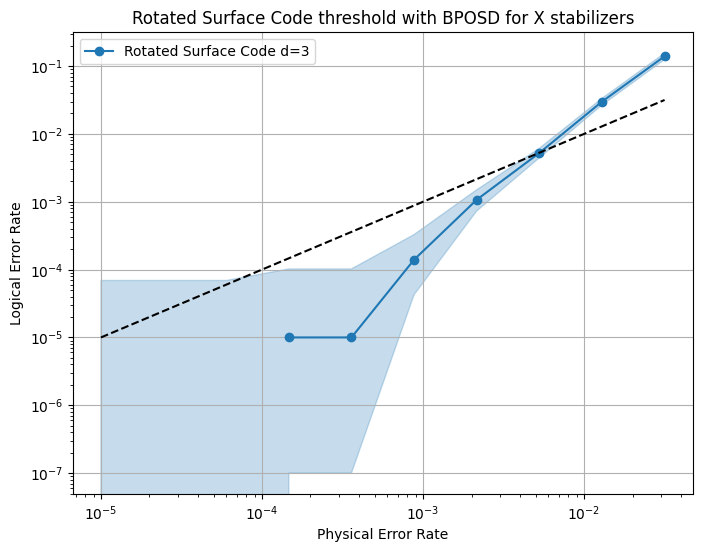

In [208]:
plot_results(samples)

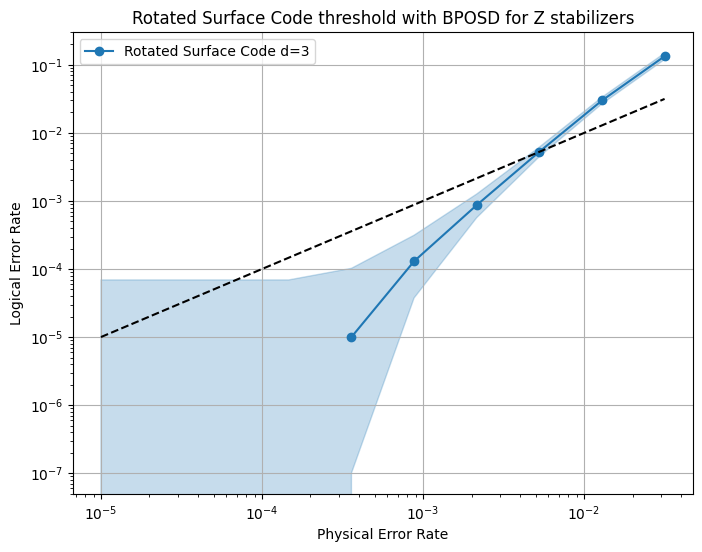

In [202]:
plot_results(samples)

In [115]:
# from sympy.abc import x, y, z
# dims = {x: 12, y: 6}
# poly_a = x**3 + y + y**2
# poly_b = y**3 + x + x**2

# code = qldpc.codes.BBCode(dims, poly_a, poly_b)
noise_range = np.logspace(-3.5, -1.5, 10)
code_name = "Rotated Surface Code"
sector = "Z"
file_name = f"{('_'.join(code_name.split())).lower()}_{sector}"
# base_code = qldpc.codes.HammingCode(2)
# group = qldpc.abstract.CyclicGroup(4)
# code = qldpc.codes.QTCode.random(group, base_code, seed=0)
# # code = qldpc.codes.SurfaceCode(3, rotated=True)


# code_a = qldpc.codes.ClassicalCode.random(5, 3, seed=0)
# code_b = qldpc.codes.ClassicalCode.random(5, 3, seed=1)

# code = qldpc.codes.HGPCode(code_a, code_b)

def generate_example_tasks():
    for noise in noise_range:
        for d in [3, 5, 7]:
            surface_code_circuit = stim.Circuit.generated(
                f"surface_code:rotated_memory_{sector.lower()}",
                rounds=2*d,
                distance=d,
                after_clifford_depolarization=noise,
                after_reset_flip_probability=noise,
                before_measure_flip_probability=noise,
                before_round_data_depolarization=noise
            )
            circuit = surface_code_circuit
            # code = qldpc.codes.SurfaceCode(d, rotated=True)
            # circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, sector=sector, repetitions=2*d).with_noise(NoiseModel(noise)))
            yield sinter.Task(
                circuit=circuit,
                detector_error_model=circuit.detector_error_model(decompose_errors=False),
                json_metadata={'noise': noise, 'd': d, 'repetitions': d },
            )


def run_simulation(overwrite=True):

    filename = f'bposd_{file_name}.csv'
    
    if overwrite:
        if pathlib.Path(filename).is_file():
            pathlib.Path(filename).unlink()

    samples = sinter.collect(
        num_workers=10,
        max_shots=10_000,
        max_errors=100,
        tasks=generate_example_tasks(),
        decoders=['bposd'],
        custom_decoders={'bposd': SinterBpOsdDecoder(
            max_iter=5,
            bp_method="ms",
            ms_scaling_factor=0.625,
            schedule="parallel",
            osd_method="osd0")
        },

        print_progress=True,
        save_resume_filepath=filename,
    )
    return(samples)

In [92]:
samples = run_simulation()
samples

Starting 10 workers...
Running...
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.00031622776601683794,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=0.00031622776601683794,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.00031622776601683794,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.0005274997063702619,repetitions=3}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=5,noise=0.0005274997063702619,repetitions=5}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=7,noise=0.0005274997063702619,repetitions=7}
    bposd processes=1  ~core_mins_left=None    shots_left=10000    errors_left=100     {d=3,noise=0.0008799225435691075,repetitions=3}
    bposd processe

[sinter.TaskStats(strong_id='b5d30e3b856c8b83ea655daac0c3b25c44d709020cbaf5eb6ba298e9b4bae585', decoder='bposd', json_metadata={'noise': 0.00031622776601683794, 'd': 3, 'repetitions': 3}, shots=10000, errors=4, seconds=1.2121941820041684),
 sinter.TaskStats(strong_id='6319927e7f204ea2638ffa19d952381f7a491dbf5885417cf21a0d947f0a4fab', decoder='bposd', json_metadata={'noise': 0.0005274997063702619, 'd': 3, 'repetitions': 3}, shots=10000, errors=11, seconds=1.2543730619981943),
 sinter.TaskStats(strong_id='6b90f1997cbef0a0c6ec27f4fe0d9684373993376e0ca3cc46c2c95dd7d821f0', decoder='bposd', json_metadata={'noise': 0.0008799225435691075, 'd': 3, 'repetitions': 3}, shots=10000, errors=40, seconds=1.490065849997336),
 sinter.TaskStats(strong_id='367b15b92e25e100901aeb9222aec981548b3304b8330fc828a27fb832aa0cd1', decoder='bposd', json_metadata={'noise': 0.00031622776601683794, 'd': 5, 'repetitions': 5}, shots=10000, seconds=12.210242819004634),
 sinter.TaskStats(strong_id='5ecf00af81f6a8cc7f2155

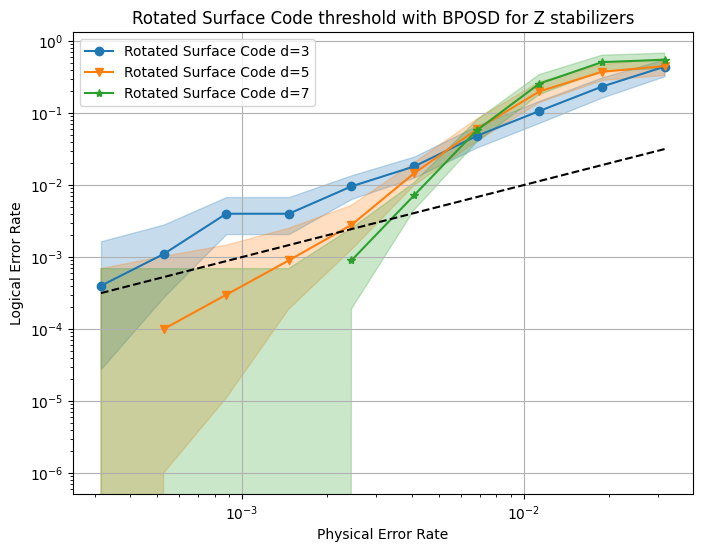

In [93]:
plot_results(samples)

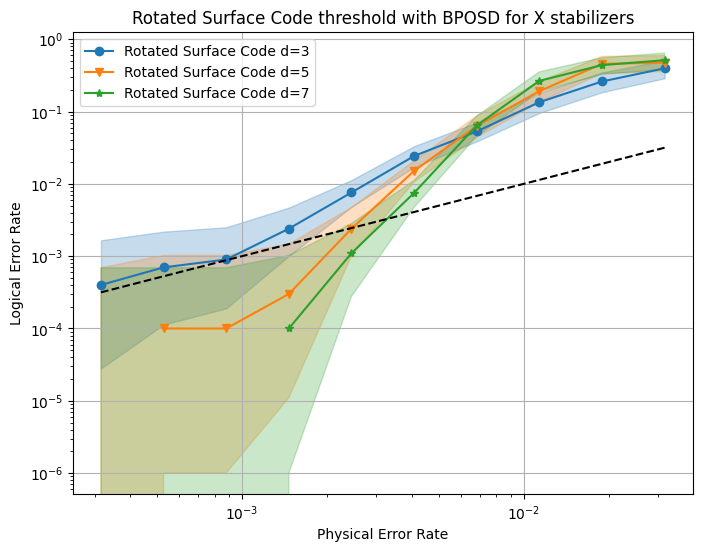

In [90]:
plot_results(samples)

# Archive

In [3]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int, decompose_errors=True, ignore_decomposition_failures=False) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model()
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

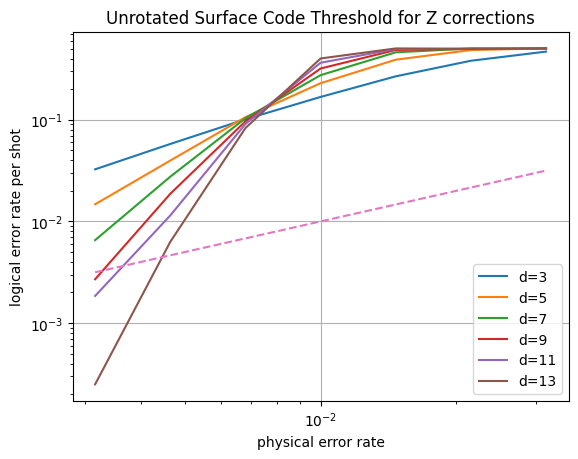

In [4]:
import matplotlib.pyplot as plt

num_shots = 20_000
noise_range = np.logspace(-3.5, -1.5, 10)
for d in [3, 5, 7, 9, 11, 13]:
    xs = []
    ys = []
    for noise in noise_range:
        surface_code_circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d*3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise
        )
        circuit = surface_code_circuit
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.grid()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for Z corrections")
plt.legend()
plt.show()

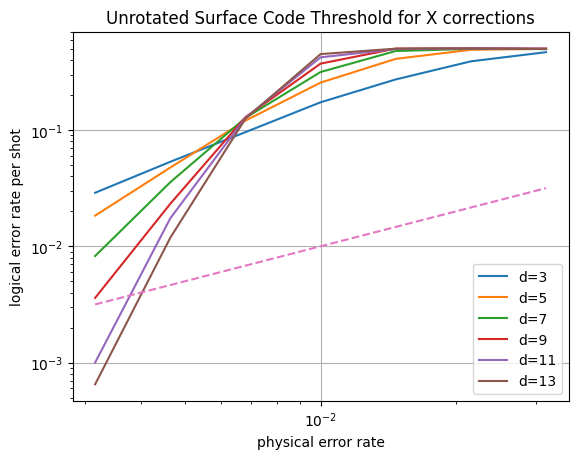

In [5]:
import matplotlib.pyplot as plt

num_shots = 20_000
noise_range = np.logspace(-2.5, -1.5, 7)
for d in [3, 5, 7, 9, 11, 13]:
    xs = []
    ys = []
    for noise in noise_range:
        surface_code_circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_x",
            rounds=d*3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise
        )
        circuit = surface_code_circuit
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.grid()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for X corrections")
plt.legend()
plt.show()

In [220]:
code = qldpc.codes.SurfaceCode(d, rotated=True)
code.matrix_x

GF([[1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 1]], order=2)

In [223]:
code.matrix_z[0]

GF([1, 1, 0, 0, 0, 0, 0, 0, 0], order=2)

In [237]:
stabilizers = [cirq.LineQubit(i) for i , element in enumerate(code.matrix_z[0]) if element == 1]

In [238]:
stabilizers

[cirq.LineQubit(0), cirq.LineQubit(1)]

In [239]:
code.matrix_z

GF([[1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1]], order=2)

In [241]:
ancillas_x = [cirq.NamedQubit(f"ax{anc_idx}") for anc_idx in range(len(code.matrix_x))]
ancillas_z = [cirq.NamedQubit(f"az{anc_idx}") for anc_idx in range(len(code.matrix_z))]

In [279]:
stabilizers = {}
for a, row in zip(ancillas_z, code.matrix_z):
    stabs = [cirq.CZ(a, cirq.LineQubit(i)) for i , element in enumerate(row) if element == 1]
    if len(stabs) == 4:
        order = [3, 1, 2, 0]
    else:
        order = [1, 0]

    stabilizers[a] = [stab for idx, stab in sorted(zip(order, stabs))]

for a, row in zip(ancillas_x, code.matrix_x):
    stabs = [cirq.CX(a, cirq.LineQubit(i)) for i , element in enumerate(row) if element == 1]
    if len(stabs) == 4:
        order = [3, 2, 1, 0]
    else:
        order = [1, 0]

    stabilizers[a] = [stab for idx, stab in sorted(zip(order, stabs))]

stabilizers[ancillas_z[0]] + stabilizers[ancillas_z[3]]
stabilizers[ancillas_x[2]] + stabilizers[ancillas_x[1]]

[cirq.CNOT(cirq.NamedQubit('ax2'), cirq.LineQubit(6)),
 cirq.CNOT(cirq.NamedQubit('ax2'), cirq.LineQubit(3)),
 cirq.CNOT(cirq.NamedQubit('ax1'), cirq.LineQubit(5)),
 cirq.CNOT(cirq.NamedQubit('ax1'), cirq.LineQubit(2))]

In [272]:
stabilizers

{cirq.NamedQubit('az0'): [cirq.CZ(cirq.NamedQubit('az0'), cirq.LineQubit(1)),
  cirq.CZ(cirq.NamedQubit('az0'), cirq.LineQubit(0))],
 cirq.NamedQubit('az1'): [cirq.CZ(cirq.NamedQubit('az1'), cirq.LineQubit(5)),
  cirq.CZ(cirq.NamedQubit('az1'), cirq.LineQubit(2)),
  cirq.CZ(cirq.NamedQubit('az1'), cirq.LineQubit(4)),
  cirq.CZ(cirq.NamedQubit('az1'), cirq.LineQubit(1))],
 cirq.NamedQubit('az2'): [cirq.CZ(cirq.NamedQubit('az2'), cirq.LineQubit(7)),
  cirq.CZ(cirq.NamedQubit('az2'), cirq.LineQubit(4)),
  cirq.CZ(cirq.NamedQubit('az2'), cirq.LineQubit(6)),
  cirq.CZ(cirq.NamedQubit('az2'), cirq.LineQubit(3))],
 cirq.NamedQubit('az3'): [cirq.CZ(cirq.NamedQubit('az3'), cirq.LineQubit(8)),
  cirq.CZ(cirq.NamedQubit('az3'), cirq.LineQubit(7))],
 cirq.NamedQubit('ax0'): [cirq.CNOT(cirq.NamedQubit('ax0'), cirq.LineQubit(4)),
  cirq.CNOT(cirq.NamedQubit('ax0'), cirq.LineQubit(3)),
  cirq.CNOT(cirq.NamedQubit('ax0'), cirq.LineQubit(1)),
  cirq.CNOT(cirq.NamedQubit('ax0'), cirq.LineQubit(0))],
 ci

In [260]:
m = [1, 2, 3, 4]
l = [3, 1, 2, 0]
[y for x,y in sorted(zip(l,m))] 

[4, 2, 3, 1]